# Find bubbles

Bubble linking performed by Trackpy, an implementation of the Crocker-Grier algorithm.


In [ ]:
import colorcet  # noqa: F401  # Registers "cet_" prefixed colormaps in plt.colormaps
from matplotlib import colormaps  # type: ignore  # pyright 1.1.333
from matplotlib.pyplot import subplot_mosaic
from numpy import diff
from numpy.linalg import norm
from pandas import CategoricalDtype, read_hdf
from seaborn import scatterplot
from src.boilercv.stages.experiments.e230920_subcool import CENTERS, bounded_ax

from boilercv.data.sets import get_dataset
from boilercv.docs import HIDE, init, nowarn, style_df
from boilercv.images import scale_bool
from boilercv.stages.experiments.e230920_subcool import (
    GBC,
    M_TO_MM,
    THERMAL_DATA,
    Col,
    get_cat_colorbar,
    get_hists,
    transform_cols,
)

init()

with nowarn(capture=True):
    from trackpy import link, quiet


quiet()

WARM_PALETTE = colormaps["cet_glasbey_warm"]
"""For plotting one approach."""
COOL_PALETTE = colormaps["cet_glasbey_cool"]
"""For plotting the other approach."""
GET_TRACKPY_CENTERS = True
"""Whether to get centers using the Trackpy approach."""
TIME = "2023-09-20T17:14:18"
"""Trial."""
STEP = 1
"""Frame step size."""
STOP = 1200
"""Last frame to analyze."""
FRAMES: list[int | None] | None = [None, STOP, STEP]
"""Frames.

A list that will become a slice. Not a tuple on input because `ploomber_engine` can't
inject tuples. The stop frame is scaled by the step size by default.
"""
SEARCH_RANGE = STEP * 30
"""Pixel distance to consider when linking objects across frames.

Scaled by the step size by default.
"""
MEMORY = STEP * 5
"""Search range for linking objects across frames.

Scaled by the step size by default.
"""
MINIMUM_LIFETIME = 0.010
"""Minimum lifetime of a bubble (s)."""

HIDE

In [ ]:
PATH_TIME = TIME.replace(":", "-")
"""Timestamp suitable for paths.

Also used in notebook parametrization.
"""

centers = read_hdf((CENTERS / f"centers_{PATH_TIME}").with_suffix(".h5"))
frames = slice(
    *(FRAMES if isinstance(FRAMES, list) else (None, centers.frame.max(), 1))
)
centers = centers[centers.frame.isin(range(frames.stop)[frames])]
filled_contours = scale_bool(
    get_dataset(PATH_TIME, frame=frames, stage="filled")["video"]
)

with style_df(centers) as styler:
    styler.hide(axis="index")

y,x,frame
298.6,180.2,0
407.3,225.1,0
437.3,202.6,0
439.4,228.0,0
298.0,180.0,1
406.0,224.9,1
437.2,202.6,1
439.0,228.1,1
297.5,179.8,2
404.7,225.2,2


In [ ]:
PX_PER_M = 20997.3753  # (px/m)
"""Pixels per meter."""
PX_PER_MM = PX_PER_M / 1000  # (px/mm)
"""Pixels per millimeter."""
# TODO: Timezone
SUBCOOLING = read_hdf(THERMAL_DATA).subcool[TIME]
"""Subcool temperature (K)."""
YPX_SURFACE_THRESHOLD = 400
"""Threshold corresponding to the boiling surface."""
YPX_DEPARTURE_THRESHOLD = 420
"""Threshold at which bubbles are considered to have departed the boiling surface."""
FRAMETIME = diff(filled_contours.time.values[:2])[0]
"""Time between frames (s)."""
MINIMUM_FRAME_LIFETIME = int(MINIMUM_LIFETIME // FRAMETIME)
"""Minimum frame lifetime of a bubble."""

HIDE

## Data

Show a subset of filled contours and contour centers.


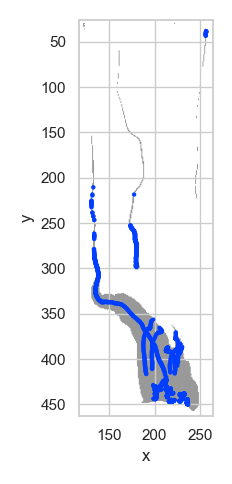

In [ ]:
composite = filled_contours.max("frame").values

with bounded_ax(composite) as ax:
    ax.imshow(~composite, alpha=0.4)

scatterplot(ax=ax, data=centers, edgecolor="none", s=10, x="x", y="y", legend=False)

HIDE

**Figure&NonBreakingSpace;1**: Bubbles in the first frame, their centroids, and bubble tracks  
First-frame bubbles in dark grey, bubble tracks in light grey, and centroids in blue.


## Find bubbles in each frame and link them

Detect individual bubbles in each frame, and then link detections across frames by application of the Crocker-Grier tracking algorithm, which takes into account centroid proximity and expected positions [@crockerMethodsDigitalVideo1996].

Initial and lifetime characteristics of long-lived bubbles are shown in **Table&NonBreakingSpace;1**. All bubbles departing the surface have an initial depth, $y$, close to the actual boiling surface, and a bimodal distribution in initial $x$, close to active nucleation sites. This information is used to determine surface and departure $y$ thresholds for alignment of bubble departures.


In [ ]:
objects = link(centers, search_range=SEARCH_RANGE, memory=MEMORY)
objects = (
    objects.rename(columns={"x": "xpx", "y": "ypx"})  # type: ignore
    .assign(
        frame_lifetime=(
            lambda df: df.groupby("particle", **GBC)["frame"].transform("count")
        )
    )
    .sort_values(["frame_lifetime", "particle", "frame"], ascending=[False, True, True])
    .assign(
        bubble=(
            lambda df: df.groupby("particle", **GBC)
            .ngroup()
            .astype(CategoricalDtype(ordered=True))
        ),
        dypx=lambda df: df.groupby("bubble", **GBC)[["ypx"]].diff().fillna(0),
        dxpx=lambda df: df.groupby("bubble", **GBC)[["xpx"]].diff().fillna(0),
        y=lambda df: df["ypx"] / PX_PER_M,
        x=lambda df: df["xpx"] / PX_PER_M,
        dy=lambda df: df["dypx"] / PX_PER_M / FRAMETIME,
        dx=lambda df: df["dxpx"] / PX_PER_M / FRAMETIME,
        distance=lambda df: norm(df[["dx", "dy"]].abs(), axis=1),
        time=lambda df: filled_contours.sel(frame=df["frame"].values)["time"],
        lifetime=lambda df: df["frame_lifetime"] * FRAMETIME,
    )
    .drop(columns=["particle"])
)
long_lived_objects = objects.query(f"frame_lifetime > {MINIMUM_FRAME_LIFETIME}")

cols = [
    Col("lifetime", "Lifetime", "s"),
    Col("time", r"$t_0$", "s"),
    Col("y", r"$y_{b0}$", **M_TO_MM),
    Col("x", r"$x_{b0}$", **M_TO_MM),
    *(hist_cols := [Col("dy", r"$v_y$")]),
]
with style_df(
    long_lived_objects.groupby("bubble", **GBC)
    .head(1)
    .set_index("bubble")
    .assign(
        **objects.pipe(
            get_hists, groupby="bubble", cols=[col.old for col in hist_cols]
        ).set_index("bubble")
    )
    .pipe(transform_cols, cols=cols)
) as styler:
    styler.background_gradient()

,Lifetime (s),$t_0$ (s),$y_{b0}$ (mm),$x_{b0}$ (mm),$v_y$
bubble,,,,,
0,0.1511,0.1293,21.13,9.482,▁▁▁▁█▄▁▁▁▁
1,0.1494,0.08929,20.96,11.08,▁▁▁▁▁▁█▁▁▁
2,0.1049,0.3058,21.06,11.01,▁▁▁▁▁█▁▁▁▁
3,0.06107,0.03034,20.97,10.99,▁▁▁▁▁▁▁█▃▁
4,0.05520,0.1093,21.40,11.25,▁▁▁▂▃█▁▁▁▁
5,0.05348,0.000,14.22,8.581,▁▃▁▁▃▅▄▄█▁
6,0.04554,0.1227,21.28,10.31,▁▁▄█▁▁▁▁▁▁
7,0.03623,0.2441,21.24,11.27,▁▁▁▂▄█▃▁▁▁
8,0.03485,0.000,20.93,10.86,▁▁▁▁█▁▁▁▁▁


**Table&NonBreakingSpace;1**: Selected properties of long-lived bubbles
Bubbles are identified by a unique particle number. Their lifetime, the time of their first appearance, their initial diameter and elevation, and lifetime histograms of selected characteristics are shown.


## History of long-lived bubbles

The paths taken by long-lived bubbles are shown in **Figure&NonBreakingSpace;2**. Two active nucleation sites are responsible for all bubbles produced, and bubbles departing from each nucleation site take one of a few predominant paths during the short period of observation.


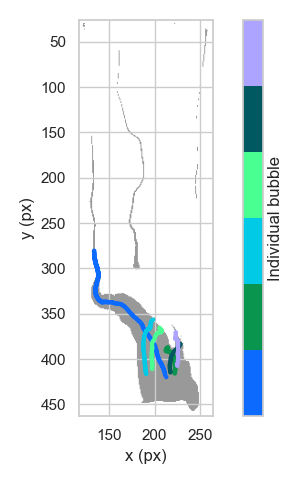

In [ ]:
departing_long_lived_objects = (
    # Find rows corresponding to stagnant or invalid bubbles
    long_lived_objects.sort_values(["bubble", "frame"])
    .groupby("bubble", **GBC)
    .apply(
        # Don't assign any other columns until invalid rows have been filtered out
        lambda df: df.assign(
            yinitpx=lambda df: df["ypx"].iat[0],
            # Initial y position is close to the surface
            began=lambda df: df["yinitpx"] > YPX_SURFACE_THRESHOLD,
            # When the bubble gets far enough away from the surface
            departed=lambda df: df["ypx"] < YPX_DEPARTURE_THRESHOLD,
        )
    )
    # Filter out invalid rows and drop the columns used to determine validity
    .pipe(lambda df: df[df["began"] & df["departed"]])
    .drop(columns=["began", "departed"])
    # Groupby again after filtering out invalid rows
    .groupby("bubble", **GBC)
    # Now columns that depend on the initial row (*.iat[0]) can be assigned
    .apply(
        lambda df: df.assign(
            frame=lambda df: df["frame"] - df["frame"].iat[0],
            time=lambda df: df["time"] - df["time"].iat[0],
            frame_lifetime=lambda df: df["frame"].iat[-1] - df["frame"].iat[0],
            lifetime=lambda df: df["frame_lifetime"] * FRAMETIME,
            yinit=lambda df: df["y"].iat[0],
            xinit=lambda df: df["x"].iat[0],
            dyinit=lambda df: df["dy"].iat[0],
            dyinitpx=lambda df: df["dy"].iat[0],
        )
    )
)

with bounded_ax(composite) as ax:
    ax.imshow(~composite, alpha=0.4)
    palette, data = get_cat_colorbar(
        ax,
        palette=COOL_PALETTE,
        data=departing_long_lived_objects.pipe(
            transform_cols,
            [
                hue := Col("bubble", "Individual bubble"),
                x := Col("xpx", "x", "px"),
                y := Col("ypx", "y", "px"),
            ],
        ),
        col=hue.new,
    )
    scatterplot(
        ax=ax,
        edgecolor="none",
        s=10,
        x=x.new,
        y=y.new,
        hue=hue.new,
        legend=False,  # type: ignore  # pyright 1.1.333
        palette=palette,
        data=data,
    )

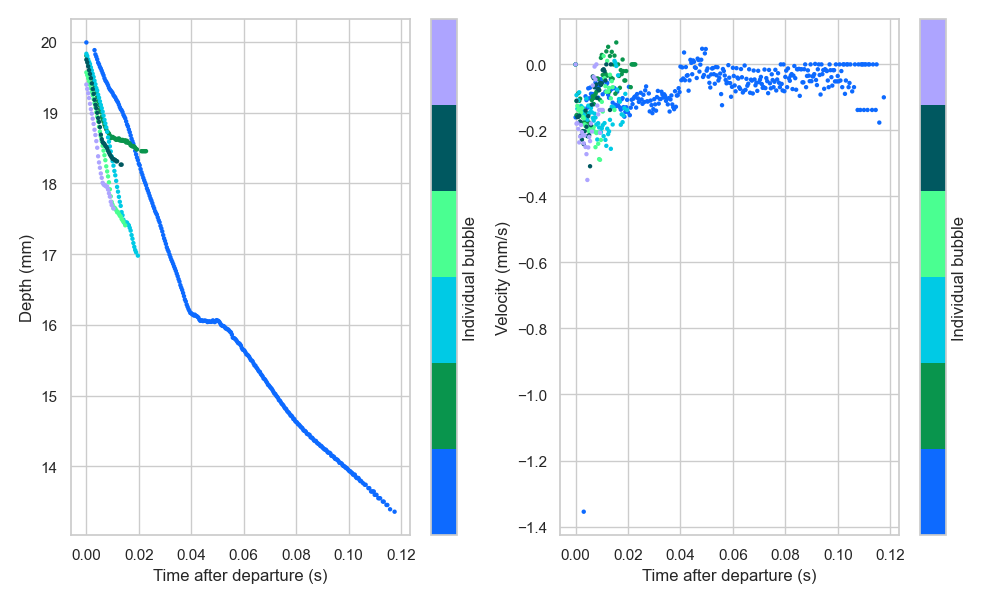

In [ ]:
cols = [
    hue := Col("bubble", "Individual bubble"),
    x := Col("time", "Time after departure", "s"),
    y := Col("y", "Depth", **M_TO_MM),
    v := Col("dy", "Velocity", "m/s", "mm/s"),
]
fig, axs = subplot_mosaic([[y.new, v.new]])
fig.set_size_inches(10, 6)
for plot, ax in axs.items():
    palette, data = get_cat_colorbar(
        ax,
        hue.new,
        COOL_PALETTE,
        departing_long_lived_objects.pipe(transform_cols, cols),
    )
    scatterplot(
        ax=ax,
        edgecolor="none",
        s=10,
        x=x.new,
        y=plot,
        hue=hue.new,
        legend=False,  # type: ignore  # pyright 1.1.333
        palette=palette,
        data=data,
    )

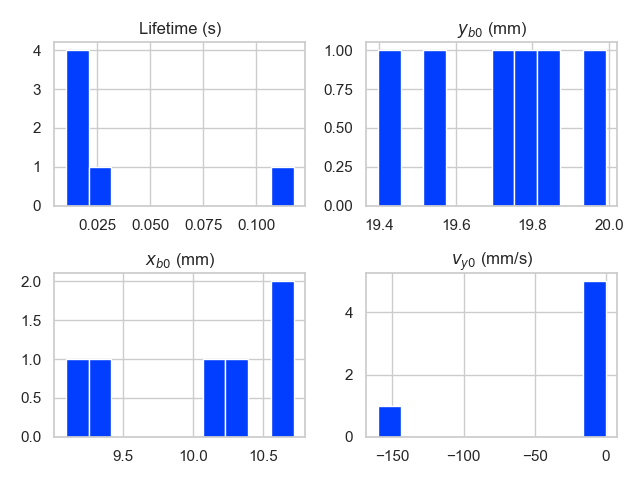

In [ ]:
(
    departing_long_lived_objects.pipe(
        transform_cols,
        [
            Col("bubble"),
            Col("lifetime", "Lifetime", "s"),
            Col("yinit", r"$y_{b0}$", **M_TO_MM),
            Col("xinit", r"$x_{b0}$", **M_TO_MM),
            Col("dyinit", r"$v_{y0}$", old_unit="m/s", new_unit="mm/s", scale=1000),
        ],
    )
    .groupby("bubble", **GBC)
    .mean()
    .set_index("bubble")
    .hist()
)

HIDE